# Deep Atrous Guided Filter Demo
This notebook provides simple demo code to view the restoration performed by our *Deep Atrous Guided Filter* (DAGF)

## Under-Display Camera Challenge

Under-Display Camera (UDC) is a new imaging system where the camera is placed behind the display screen, achieving truly bezel-free displays, larger screen-to-body ratio, superior video conferencing experience, etc. The [Under-Display Camera Challenge](https://rlq-tod.github.io/challenge2.html), held in conjunction with the RLQ'20 Workshop in ECCV 2020, sought efficient and high performing solutions for restoration of high-resolution Transparent-OLED (TOLED) and Pentile OLED (POLED) UDC images. UDC images suffer from a variety of degradations, including blur, low-light and colour degradation. Our method, *DAGF*, operates directly on the high-resolution images, maintaining efficiency by using a guided-filter framework. DAGF is effective in restoring highly  degraded POLED images, by incorporating larger context (through atrous convolutions) and imitating multi-scale processing (by employing such convolutions in parallel). Our method placed 2nd in the POLED track and 5th in the TOLED track.

![](figs/fig_1.png)

## DAGF Overview
Our model restores an image in two-stages : A low-resolution network (LRNet) first restores the image at a lower resolution, which is subsequently used by the Guided Filter Network as a filtering input to produce a high-resolution output.
![](figs/fig_2.png)

In [1]:
# install requirements
!pip install -r requirements.txt

  Cloning https://github.com/S-aiueo32/contextual_loss_pytorch.git to /private/var/folders/91/ym4gmlrd0tq37lhq_5x9b_n80000gn/T/pip-req-build-vbcdlk6v
  Running command git clone -q https://github.com/S-aiueo32/contextual_loss_pytorch.git /private/var/folders/91/ym4gmlrd0tq37lhq_5x9b_n80000gn/T/pip-req-build-vbcdlk6v
  Created wheel for contextual-loss-pytorch: filename=contextual_loss_pytorch-latest-py3-none-any.whl size=7323 sha256=05ff00c6282b3167330a8a8d13ccb61cbb04085373f4d2168e1baee344992a3d
  Stored in directory: /private/var/folders/91/ym4gmlrd0tq37lhq_5x9b_n80000gn/T/pip-ephem-wheel-cache-y8a4p9n5/wheels/78/98/8b/ee9c552ea8ad17fe35e5d9c48a41829af42a8d8411a0703e0a
Successfully built contextual-loss-pytorch


In [2]:
# Imports
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path
import os
import warnings
warnings.simplefilter("ignore")

In [3]:
args = {
    "image_dir": Path("data"),
    "ckpt_dir": Path("ckpts"),
    "pixelshuffle_ratio": 2,
    "guided_map_kernel_size": 3,
    "guided_map_channels": 16,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu"
}


# Convert dictionary to object notation
class Tupperware(object):
    def __init__(self, entries):
        self.__dict__.update(entries)
        
args = Tupperware(args)

In [4]:
# download pre-trained weights for POLED and TOLED
if not args.ckpt_dir.exists():
    os.mkdir(args.ckpt_dir)
    
poled_path = str(args.ckpt_dir / 'poled_final.pth')
toled_path = str(args.ckpt_dir / 'toled_final.pth')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r' -O {poled_path}
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Fmub65AsMK231czImqsZWprxDCNx21AA' -O {toled_path}

--2020-08-12 12:31:55--  https://docs.google.com/uc?export=download&id=1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r
Resolving docs.google.com (docs.google.com)... 142.250.67.46
Connecting to docs.google.com (docs.google.com)|142.250.67.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6fjvskhu5bc8up7kj8hkmlv6rgton9mm/1597215675000/05935635026363679465/*/1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r?e=download [following]
--2020-08-12 12:31:57--  https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6fjvskhu5bc8up7kj8hkmlv6rgton9mm/1597215675000/05935635026363679465/*/1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r?e=download
Resolving doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)... 216.58.197.65
Connecting to doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)|216.58.197.65|:443... connected.
HTTP

In [5]:
from models.guided_filter import DeepAtrousGuidedFilter
from utils.model_serialization import load_state_dict
device = args.device
model = DeepAtrousGuidedFilter(args).to(device)
model.eval();

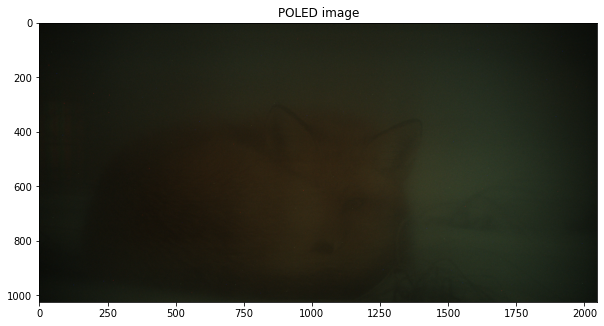

In [6]:
# Poled demo
poled_img_path = args.image_dir / "ex_poled.png"
poled_img = cv2.imread(str(poled_img_path))[:,:,::-1]/255

# visualise image
plt.figure(figsize=(10, 20))
plt.imshow(poled_img)
plt.title('POLED image')
# preprocessing
poled_img = torch.Tensor(poled_img.copy()).permute(2, 0, 1).unsqueeze(0)
poled_img = poled_img.mul(2).sub(1) 

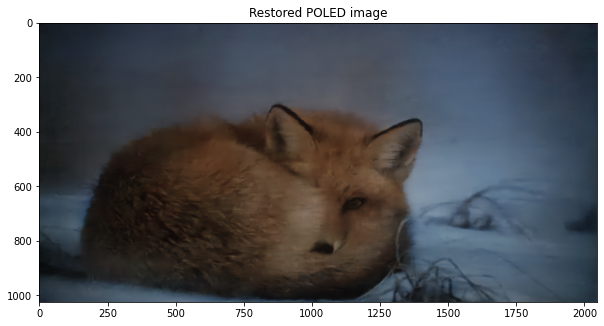

In [7]:
# load pre-trained weights
ckpt = torch.load(poled_path, map_location=torch.device(device))
load_state_dict(model, ckpt['state_dict'])

with torch.no_grad():
    poled_out = model(poled_img.to(device))[0].cpu().permute(1,2,0).numpy()
poled_out = (poled_out + 1)/2
plt.figure(figsize=(10, 20))
plt.imshow(poled_out)
plt.title('Restored POLED image')
plt.show()

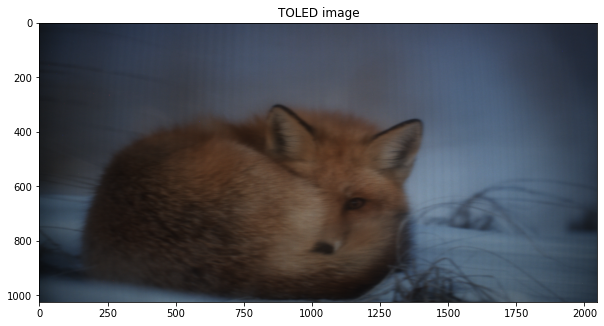

In [8]:
# Toled demo
toled_img_path = args.image_dir / "ex_toled.png"
toled_img = cv2.imread(str(toled_img_path))[:,:,::-1]/255

# visualise image
plt.figure(figsize=(10, 20))
plt.imshow(toled_img)
plt.title('TOLED image')

# preprocessing
toled_img = torch.Tensor(toled_img.copy()).permute(2, 0, 1).unsqueeze(0)
toled_img = toled_img.mul(2).sub(1) 

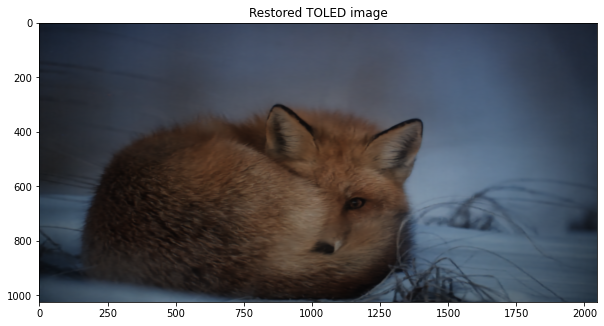

In [9]:
# load pre-trained weights
ckpt = torch.load(toled_path, map_location=torch.device(device))
load_state_dict(model, ckpt['state_dict'])

with torch.no_grad():
    toled_out = model(toled_img.to(device))[0].cpu().permute(1,2,0).numpy()
toled_out = (toled_out + 1)/2
plt.figure(figsize=(10, 20))
plt.imshow(toled_out)
plt.title('Restored TOLED image')
plt.show()